**Import thư viện**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#Các chỉ số đánh giá mô hình
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

**Đọc dữ liệu**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BTNhom

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1XiA3MhYoc5Hn-a0SULtdyyQNWK2CIzkS/BTNhom


In [3]:
df = pd.read_csv('./Data_BTL2/du_lieu_FPT3.csv')
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,28/10/2024,134.1,135.0,133.6,134.9,--,0.9,0.67,"1,506,000",202.64
1,25/10/2024,134.3,134.6,133.6,134.0,--,-0.3,-0.22,"1,839,000",246.29
2,24/10/2024,134.2,134.3,133.8,134.3,--,0.1,0.07,"2,277,200",305.37
3,23/10/2024,132.9,134.8,132.6,134.2,--,1.1,0.83,"3,015,100",403.48
4,22/10/2024,135.7,135.7,133.0,133.1,--,-2.4,-1.77,"6,009,200",806.44
...,...,...,...,...,...,...,...,...,...,...
2498,24/10/2014,50.0,50.5,49.6,49.8,8.9,-0.1,-0.20,"480,290",23.95
2499,23/10/2014,50.0,51.0,49.8,49.9,8.91,-0.6,-1.19,"596,130",29.91
2500,22/10/2014,50.5,51.0,50.0,50.5,9.02,0.5,1.00,"410,150",20.71
2501,21/10/2014,50.0,50.5,49.8,50.0,8.93,0.0,0.00,"345,010",17.24


**Mô tả dữ liệu**

In [4]:
df.head()

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,28/10/2024,134.1,135.0,133.6,134.9,--,0.9,0.67,"1,506,000",202.64
1,25/10/2024,134.3,134.6,133.6,134.0,--,-0.3,-0.22,"1,839,000",246.29
2,24/10/2024,134.2,134.3,133.8,134.3,--,0.1,0.07,"2,277,200",305.37
3,23/10/2024,132.9,134.8,132.6,134.2,--,1.1,0.83,"3,015,100",403.48
4,22/10/2024,135.7,135.7,133.0,133.1,--,-2.4,-1.77,"6,009,200",806.44


In [5]:
df.shape

(2503, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ngày              2503 non-null   object 
 1   Giá mở            2503 non-null   float64
 2   Giá cao nhất      2503 non-null   float64
 3   Giá thấp nhất     2503 non-null   float64
 4   Giá đóng          2503 non-null   float64
 5   Giá điều chỉnh    2503 non-null   object 
 6   Giá trị thay đổi  2503 non-null   float64
 7   % thay đổi        2503 non-null   float64
 8   Tổng KL GD        2503 non-null   object 
 9   Tổng GT GD        2503 non-null   object 
dtypes: float64(6), object(4)
memory usage: 195.7+ KB


In [7]:
df.describe()

,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá trị thay đổi,% thay đổi
count,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000
mean,66.110088,66.818438,65.470336,66.130224,0.069828,0.102920
std,25.334373,25.658075,25.035448,25.368850,1.192400,1.607907
min,38.800000,39.650000,38.500000,38.800000,-10.800000,-11.030000
25%,46.800000,47.200000,46.400000,46.800000,-0.400000,-0.660000
50%,53.000000,54.000000,52.500000,53.200000,0.000000,0.000000
75%,84.600000,85.300000,83.800000,84.650000,0.500000,0.865000
max,144.300000,146.500000,143.100000,146.500000,7.800000,7.000000


**Tiền xử lý dữ liệu**

In [8]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Tổng KL GD'] = df['Tổng KL GD'].replace({',': ''}, regex=True).astype(float)
df['Tổng GT GD'] = df['Tổng GT GD'].replace({',': ''}, regex=True).astype(float)

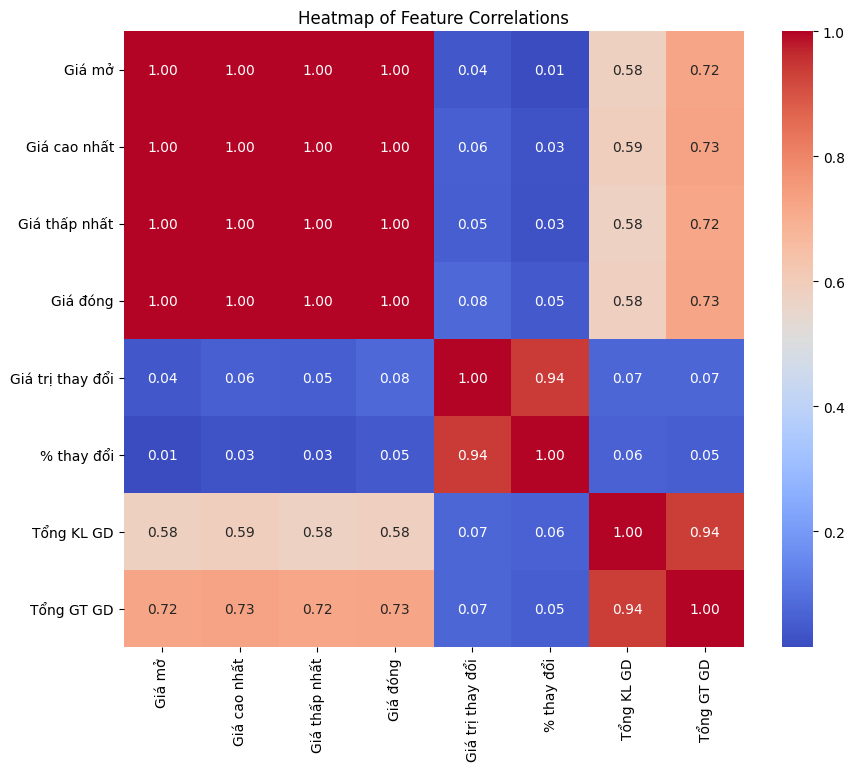

In [9]:
df_numeric = df.drop(columns=['Ngày', 'Giá điều chỉnh'])
# Vẽ heatmap thể hiện mối quan hệ giữa các cột
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Feature Correlations")
plt.show()

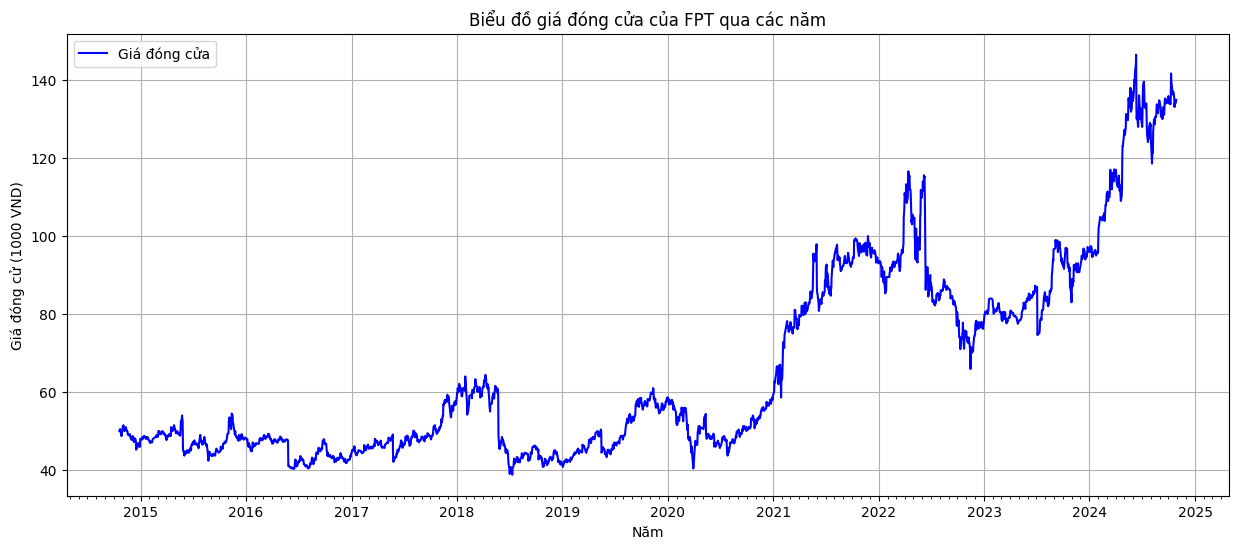

In [10]:
# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

plt.figure(figsize=(15, 6))
# Tạo đồ thị giá đóng cửa qua các năm
plt.plot(df['Ngày'], df['Giá đóng'], label='Giá đóng cửa', color='blue')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cử (1000 VND)')
plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.grid(True)
plt.show()

In [11]:
df1 = pd.DataFrame(df,columns=['Ngày', 'Giá mở', 'Giá đóng', 'Giá cao nhất', 'Giá thấp nhất'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Giá mở,Giá đóng,Giá cao nhất,Giá thấp nhất
Ngày,,,,
2014-10-20,50.5,50.0,51.0,50.0
2014-10-21,50.0,50.0,50.5,49.8
2014-10-22,50.5,50.5,51.0,50.0
2014-10-23,50.0,49.9,51.0,49.8
2014-10-24,50.0,49.8,50.5,49.6
...,...,...,...,...
2024-10-22,135.7,133.1,135.7,133.0
2024-10-23,132.9,134.2,134.8,132.6
2024-10-24,134.2,134.3,134.3,133.8


In [12]:
def normalize(data, train_split):
    scaler = StandardScaler()
    scaler.fit(data[:train_split])
    normalized_data = scaler.transform(data)

    return normalized_data, scaler

def inverse_normalize(normalized_data, scaler):
    return scaler.inverse_transform(normalized_data)

# Chuẩn hóa và chia dữ liệu huấn luyện
train_split = int(0.7 * int(df1.shape[0]))
test_split = int(0.15 * int(df1.shape[0]))

# Chuẩn dữ liệu
df1_normalized, scaler = normalize(df1.values, train_split + test_split)

# Chia dữ liệu
train_data = df1_normalized[:train_split]
val_data = df1_normalized[train_split:train_split + test_split]
test_data = df1_normalized[train_split + test_split:]

# Xác định phương thức dự báo
past = 15
future = 1
step = 1
batch_size = 256
# Tạo dữ liệu huấn luyện
start_train = past + future - 1
end_train = start_train + train_split

X_train = train_data
y_train = df1_normalized[start_train:end_train, [0]]
sequence_length = int(past / step)
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Tạo dữ liệu kiểm chứng
end_val = end_train + test_split

X_val = val_data
y_val = df1_normalized[end_train:end_val, [0]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Tạo dữ liệu kiểm tra
end_X_test = len(test_data) - past

X_test = test_data[:end_X_test]
y_test = df1_normalized[end_val:, [0]]  # Chỉ lấy cột đầu tiên (Giá đóng)

dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [13]:
# print(X_train)
# print(y_train)

In [14]:
# print(X_val)
# print(y_val)

In [15]:
# print(X_test)
# print(y_test)

In [16]:
# dataset_train

In [17]:
# data

In [18]:
X_train

array([[-0.45911478, -0.48626142, -0.45925982, -0.46190841],
       [-0.48644755, -0.48626142, -0.48616031, -0.47301015],
       [-0.45911478, -0.4589531 , -0.45925982, -0.46190841],
       ...,
       [ 2.15936494,  2.06433568,  2.09628693,  2.13034835],
       [ 2.08283317,  2.03702736,  2.03710585,  2.09704312],
       [ 2.03910074,  1.96602573,  1.97254467,  2.03043267]])

In [19]:
y_train

array([[-0.45911478],
       [-0.43178201],
       [-0.43178201],
       ...,
       [ 2.08283317],
       [ 2.03910074],
       [ 2.16483149]])

**Xây dựng và huấn luyện mô hình**

In [20]:
#xây dựng mô hình
model = model = tf.keras.Sequential() #tạo lớp mạng cho dữ liệu đầu vào
model.add(tf.keras.layers.Input(shape=(sequence_length, X_train.shape[1])))
#2 lớp LSTM
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))
#2 lớp Dense
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 256)             │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 472,705 (1.80 MB)

 Trainable params: 472,705 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#huấn luyện mô hình
save_model = "./Model/Xuan/best_model2_BTL2.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
history = model.fit(dataset_train,
                    epochs=100,
                    batch_size=32,
                    verbose=2,
                    callbacks=[best_model],
                    validation_data=dataset_val)

Epoch 1/100

Epoch 1: loss improved from inf to 0.16844, saving model to ./Model/Xuan/best_model2_BTL2.keras
7/7 - 11s - 2s/step - loss: 0.1684 - mean_absolute_error: 0.3050 - val_loss: 0.2662 - val_mean_absolute_error: 0.4364
Epoch 2/100

Epoch 2: loss did not improve from 0.16844
7/7 - 4s - 504ms/step - loss: 0.1761 - mean_absolute_error: 0.2316 - val_loss: 0.4506 - val_mean_absolute_error: 0.6119
Epoch 3/100

Epoch 3: loss improved from 0.16844 to 0.09643, saving model to ./Model/Xuan/best_model2_BTL2.keras
7/7 - 2s - 350ms/step - loss: 0.0964 - mean_absolute_error: 0.1930 - val_loss: 0.7064 - val_mean_absolute_error: 0.7574
Epoch 4/100

Epoch 4: loss improved from 0.09643 to 0.04231, saving model to ./Model/Xuan/best_model2_BTL2.keras
7/7 - 2s - 351ms/step - loss: 0.0423 - mean_absolute_error: 0.1624 - val_loss: 0.1202 - val_mean_absolute_error: 0.2374
Epoch 5/100

Epoch 5: loss improved from 0.04231 to 0.03445, saving model to ./Model/Xuan/best_model2_BTL2.keras
7/7 - 2s - 352ms/s

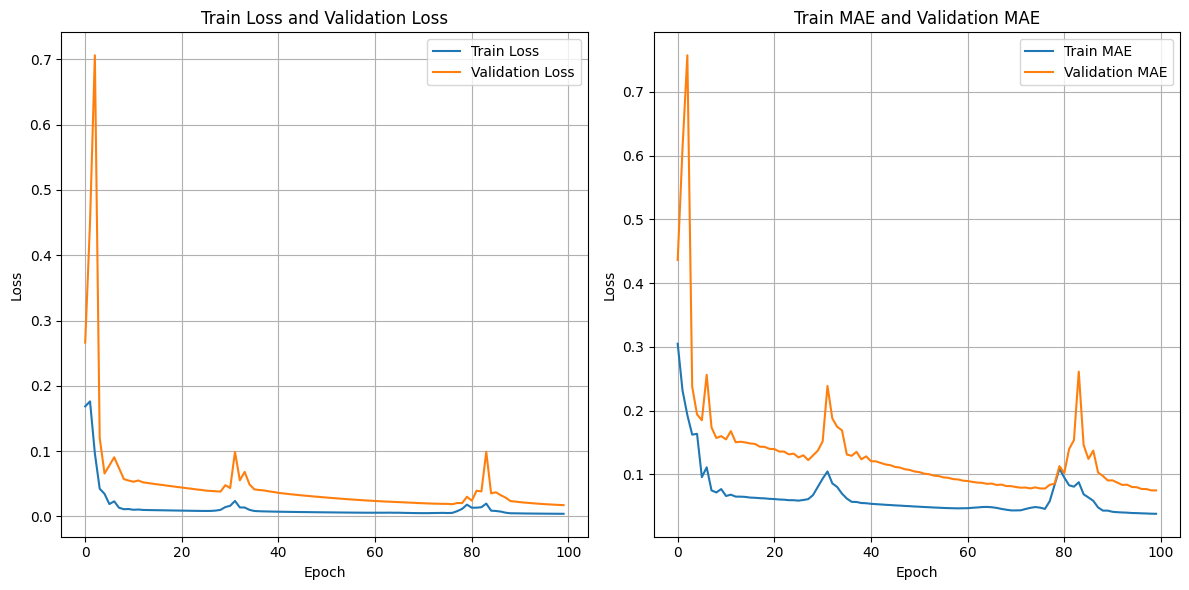

In [22]:
plt.figure(figsize=(12, 6))
# Vẽ biểu đồ hàm loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Validation Loss')
plt.grid(True)

# Vẽ biểu đồ hàm MAE
plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train MAE and Validation MAE')

plt.grid(True)
plt.tight_layout()
plt.show()


**Tái sử dụng mô hình**

In [23]:
final_model = load_model("./Model/Xuan/best_model2_BTL2.keras")

In [24]:
targer_df = pd.DataFrame(df,columns=['Giá đóng'])
targer_df = targer_df.iloc[:train_split + test_split]
targer_df_normalize, scaler_fn = normalize(targer_df.values, train_split + test_split)

y_train_fn = np.concatenate([y.numpy() for _, y in dataset_train], axis=0)
y_train_fn = inverse_normalize(y_train_fn, scaler_fn) #giá thực
y_train_fn_predict = final_model.predict(dataset_train)
y_train_fn_predict_inverse = inverse_normalize(y_train_fn_predict, scaler_fn)

y_val_fn = np.concatenate([y.numpy() for _, y in dataset_val], axis=0)
y_val_fn_inverse = inverse_normalize(y_val_fn, scaler_fn) #giá thực
y_val_fn_predict = final_model.predict(dataset_val)
y_val_fn_predict_inverse = inverse_normalize(y_val_fn_predict, scaler_fn)


y_test_fn = np.concatenate([y.numpy() for _, y in dataset_test], axis=0)
y_test_fn_inverse = inverse_normalize(y_test_fn, scaler_fn) #giá thực
y_test_fn_predict = final_model.predict(dataset_test)
y_test_fn_predict_inverse = inverse_normalize(y_test_fn_predict, scaler_fn)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


**Đánh giá của mô hình**

<ipython-input-25-6b100c5297b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1.loc[:,'Giá đóng dự đoán'] = y_train_fn_predict_inverse
<ipython-input-25-6b100c5297b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df1.loc[:,'Giá đóng dự đoán'] = y_val_fn_predict_inverse
<ipython-input-25-6b100c5297b9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

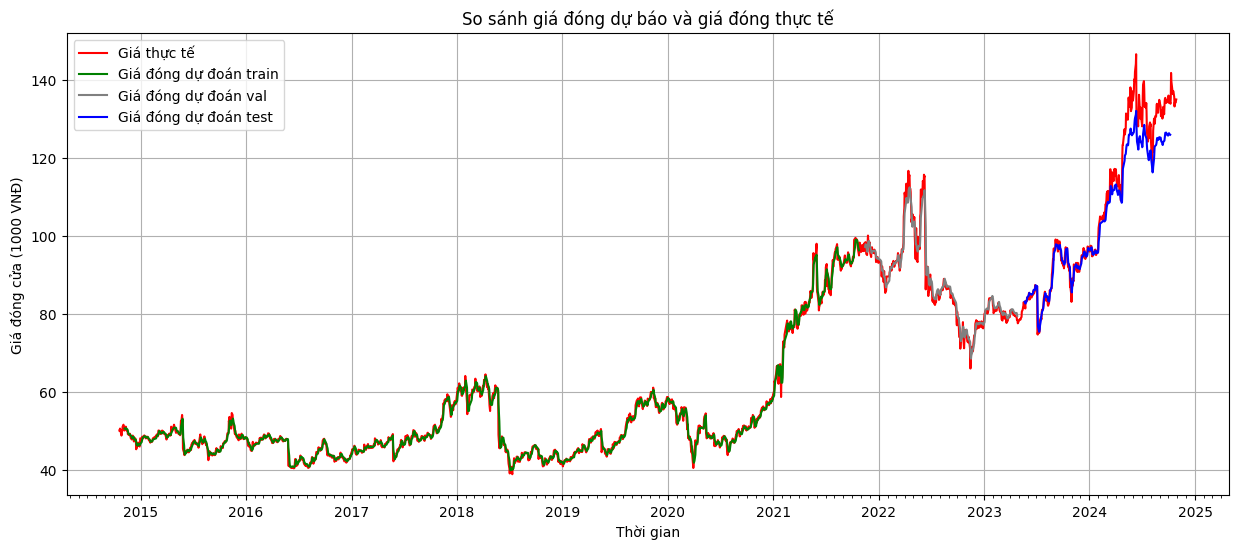

In [25]:
# Lập biểu đồ so sánh
train_df1 = df1[past - future : train_split]
val_df1 = df1[start_train + train_split - future:train_split + test_split]
test_df1 = df1[start_train + train_split + test_split - future : len(df1) - past]

plt.figure(figsize=(15,6))

#Biểu đồ giá đóng
plt.plot(df1.index, df1['Giá đóng'], label='Giá thực tế', color='red')

# Thêm dữ liệu dự đoán cho train
train_df1.loc[:,'Giá đóng dự đoán'] = y_train_fn_predict_inverse
plt.plot(train_df1.index, train_df1['Giá đóng dự đoán'], label='Giá đóng dự đoán train', color='green')

val_df1.loc[:,'Giá đóng dự đoán'] = y_val_fn_predict_inverse
plt.plot(val_df1.index, val_df1['Giá đóng dự đoán'], label='Giá đóng dự đoán val', color='gray')

# Thêm dữ liệu dự đoán cho test
test_df1.loc[:,'Giá đóng dự đoán'] = y_test_fn_predict_inverse
plt.plot(test_df1.index, test_df1['Giá đóng dự đoán'], label='Giá đóng dự đoán test', color='blue')

plt.title('So sánh giá đóng dự báo và giá đóng thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (1000 VNĐ)')
plt.legend(loc='best')
plt.grid(True)

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.show()


In [26]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train_fn_predict, y_train_fn_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (1000 VNĐ):',mean_absolute_error(y_train_fn,y_train_fn_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train_fn,y_train_fn_predict))

Độ phù hợp tập train: 1.0
Sai số tuyệt đối trung bình trên tập train (1000 VNĐ): 53.09927543041474
Phần trăm sai số tuyệt đối trung bình tập train: 1.0090081483910318


In [27]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test_fn,y_test_fn_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (1000 VNĐ):',mean_absolute_error(y_test_fn,y_test_fn_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test_fn,y_test_fn_predict))

Độ phù hợp tập test: 0.9329240776354757
Sai số tuyệt đối trung bình trên tập test (1000 VNĐ): 0.19457417123679466
Phần trăm sai số tuyệt đối trung bình tập test: 0.06235751634289604


**Thử dự đoán giá tương lai và so sánh với giá ngày cuối**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


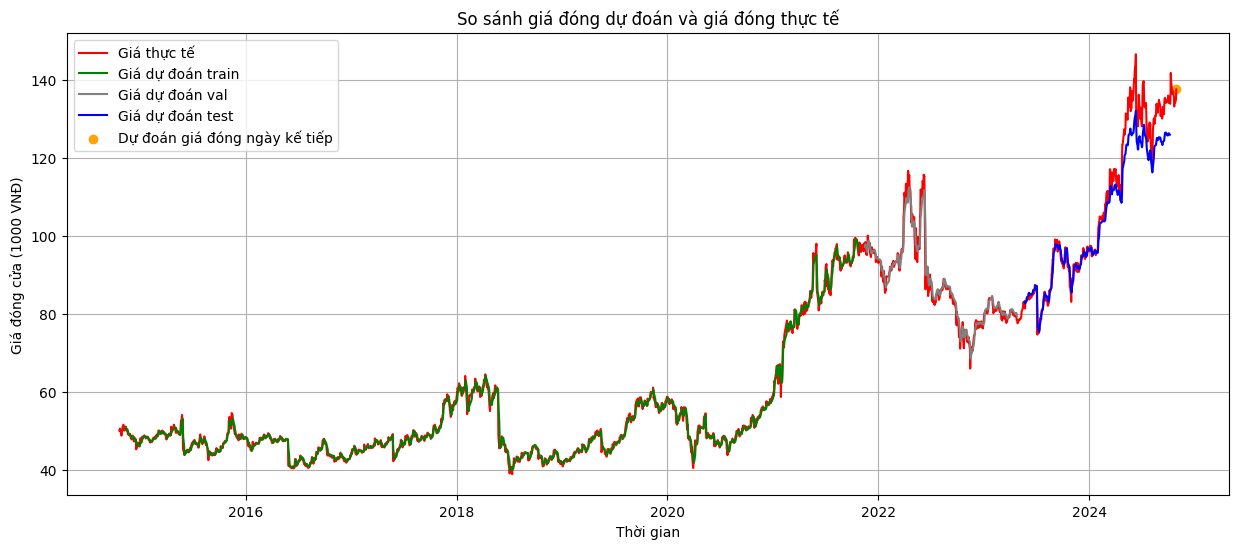

In [28]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Giá đóng'].iloc[-1]])

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized, scaler_closing = normalize(next_closing_price.reshape(-1, 1), len(df1))  # Chuyển thành mảng 2D
df1_normalized2, scaler_df1 = normalize(df1, len(df1))

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
X_next = df1_normalized2[-15:]  # Lấy 15 giá đóng gần nhất
X_next = np.reshape(X_next, (1, X_next.shape[0], X_next.shape[1]))
y_next_predict = final_model.predict(X_next)
y_next_predict = inverse_normalize(y_next_predict, scaler_closing)

#Thêm dữ liệu dự đoán của ngày kế tiếp vào dtFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Giá đóng':[y_next_predict[0][0]]})
df = pd.concat([df, df_next])

plt.figure(figsize=(15,6))
# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.plot(df['Ngày'], df['Giá đóng'], label='Giá thực tế', color='red')
plt.plot(train_df1.index, train_df1['Giá đóng dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(val_df1.index, val_df1['Giá đóng dự đoán'], label='Giá dự đoán val', color='gray')
plt.plot(test_df1.index, test_df1['Giá đóng dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán giá đóng ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (1000 VNĐ)')
plt.title('So sánh giá đóng dự đoán và giá đóng thực tế')
plt.legend()

plt.grid(True)
plt.show()


In [29]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Giá đóng'].iloc[-1]

# Tạo dfFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': df['Ngày'].iloc[-1], 'Giá đóng dự đoán': [y_next_predict[0][0]], 'Giá đóng thực tế': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày  Giá đóng dự đoán  Giá đóng thực tế
0 2024-10-29        137.491318        137.491318
